# Object detection #3
sources: https://pyimagesearch.com/2020/07/06/region-proposal-object-detection-with-opencv-keras-and-tensorflow/

In the last part, we've run through the benefits of RPNs like selective search over the naive image pyramid and sliding window method. Now we will "plug-in" selective search to our object detection pipeline.

## Summary
Following are the steps for converting an image classifier into an object detector:
1) input image

2) construct image pyramid

3) selective search RPN to generate ROIs

4) pass ROI through CNN for classification

5) min probability test passes, record class and bbox

6) apply class-wise NMS

7) return results

*ROI = region of interest

*non-maxima suppression (NMS) means collapsing weak overlapping bboxes in favour of more confident ones, ultimately forming one bbox per object

## Dependencies

In [1]:
import tensorflow as tf
import numpy as np
from keras.applications import ResNet50
from keras.applications.resnet import preprocess_input
from keras.preprocessing.image import img_to_array
from keras.applications import imagenet_utils
import matplotlib.pyplot as plt
import time
import cv2

## NMS
non-maxima suppression (NMS) removes redundant bboxes by discarding those that has overlaps above a given threshold

In [2]:
# Felzenszwalb et al.
# boxes should be defined as [(start_x, start_y, end_x, end_y),...]
def NMS(boxes, overlapThresh):
    if len(boxes) == 0:
        return []
    # picked indexes
    pick = []
    # coords of all bboxes
    x1 = boxes[:,0]
    y1 = boxes[:,1]
    x2 = boxes[:,2]
    y2 = boxes[:,3]
    # compute area of bboxes
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    # get indexes sorted by bottom right coord
    idxs = np.argsort(x1)
    # while there are still bboxes not checked
    while len(idxs) > 0:
        # grab the last idx
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i) # list of boxes picked (curr is cfm picked as overlapped bboxes are discarded beforehand)
        suppress = [] # list of boxes to be deleted
        idxs = idxs[:-1]
        # compare all bboxes with last
        for pos in range(0, last):
            j = idxs[pos]
            # compare box i and j for overlap
            xx1 = max(x1[i], x1[j])
            yy1 = max(y1[i], y1[j])
            xx2 = min(x2[i], x2[j])
            yy2 = min(y2[i], y2[j])
            w = max(0, xx2 - xx1 + 1)
            h = max(0, yy2 - yy1 + 1)
            overlap = float(w * h) / area[j]
            # overlap above threshold? Pos to be deleted
            if overlap > overlapThresh:
                suppress.append(pos)
        # delete all indexes from the index list that are in suppression list
        idxs = np.delete(idxs, suppress)
    # only picked boxes returned
    return boxes[pick]

## Selective search

In [3]:
def selective_search(img):
    ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
    ss.setBaseImage(img)
    # use fast quality
    ss.switchToSelectiveSearchFast()
    start = time.time()
    rects = ss.process()
    end = time.time()
    print('Selective search took {:.4f}s'.format(end - start))
    print('{} total region proposals'.format(len(rects)))
    return rects

## CNN
We will load a CNN model pre-trained with ImageNet weights.

In [4]:
model = ResNet50(weights="imagenet", include_top=True)

## Constants and test data

In [5]:
WIDTH = 600
INPUT_SIZE = (224, 224) # for classifier
MIN_CONF = 0.99 # min confidence for classifiying
FILTERS = ["hummingbird"] # list of ImageNet clases we wish to consider

In [6]:
img = cv2.imread('hummingbird.png')
img = np.flip(img, axis=-1)
resize_ratio = WIDTH / img.shape[1]
img = cv2.resize(img, (int(img.shape[1] * resize_ratio), int(img.shape[0] * resize_ratio)), interpolation=cv2.INTER_LINEAR)
(H, W) = img.shape[:2]

## Running selective search
Run the selective search then filter the output results according to dimens (we do not want ROIs that are too small)

In [7]:
rects = selective_search(img)

Selective search took 1.4132s
643 total region proposals


In [8]:
rois = []
boxes = []
for (x, y, w, h) in rects:
    # if ROI dimens < 10% of the img (likely to be false positives/noises)
    if w / float(W) < 0.1 or h / float(H) < 0.1:
        continue
    # extract the ROI pixels from img then resize it to INPUT_SIZE
    roi = img[y:y + h, x: x + w]
    roi = cv2.resize(roi, INPUT_SIZE)
    # further preprocessing as required by ImageNet
    roi = img_to_array(roi)
    roi = preprocess_input(roi)
    # update our lists
    rois.append(roi)
    boxes.append((x, y, x + w, y + h))

## Run predictions on ROI
Run the ROIs (resized to original scale) through the classifier.

In [9]:
rois = np.array(rois, dtype=np.float32)
print('Classifying ROIs...')
start = time.time()
model_preds = model.predict(rois)
end = time.time()
print('Classifying ROIs took {:.5f}s'.format(end - start))

Classifying ROIs...
Classifying ROIs took 16.10932s


Decode the preds and init a dict which maps class labels to any ROIs associated with that label

In [10]:
preds = imagenet_utils.decode_predictions(model_preds, top=1)
labels = {}
for (i, p) in enumerate(preds):
    #  pred info for curr ROI
    (imagenetID, label, prob) = p[0]
    # not in filters we want
    if label not in FILTERS:
        continue
    # filter out weak detections
    if prob >= MIN_CONF:
        box = boxes[i]
        # append pred to label key of labels
        L = labels.get(label, [])
        L.append((box, prob))
        labels[label] = L

## Visualize the results
Apply NMS and visualize results

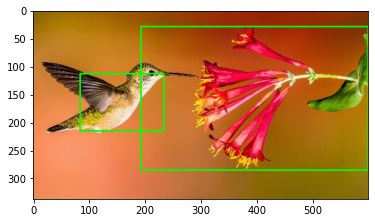

In [11]:
clone = img.copy()
for label in labels.keys():
    # run boxes through NMS
    boxes = np.array([x[0] for x in labels[label]])
    boxes = NMS(boxes, 0.3)
    # all bboxes over the curr label
    for box in boxes:
        # draw on img
        (start_x, start_y, end_x, end_y) = box
        cv2.rectangle(clone, (start_x, start_y), (end_x, end_y), (0, 255, 0), 2)
plt.imshow(clone)